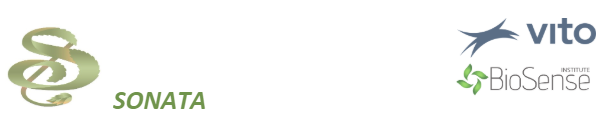
<br>
## training on VITO's hierarchical habitat mapping workflow for openEO processing platform
<br>
Copyrights, license and restrictions <br>
All code snippets, visualizations or/and workflow ideas are property of VITO. Work has been developed since 2021 and is still in development by VITO.
Showed public and private repositories are owned by VITO. <br>
(Re)sharing is only allowed with proper citation of the owners. Publications (peer-review, reports, ...) based partly and/or fully on VITO's hierarchical habitat mapping framework or on one of the provided GitHub repositories must be prior aligned with Dr. Marcel Buchhorn.
Code usage is allowed with proper citation, see author list in repository.
<br>
base repository: https://github.com/ESA-WEED-project/eo_processing

### Working with EVA and SPlot Database


#### Preparation of databases for feature extraction


##### In QGIS, import the header file and clip the point within the Pannonian zone. Based on the PlotObservationID, we can filter the points from the species file to only keep the ones within the Pannonian zone too (the species file does not contain coorinates).

In [1]:
import pandas as pd
import geopandas as gpd


##### start with EVA points

In [3]:
EVA_header = gpd.read_file('/data/habitat/serbia/online_workshop/226_WEED_20250110_notJUICE_header_PAN.shp')

/home/lorigiagnacovo/.conda/envs/weed2/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from CP1252 to UTF-8.  This warning will not be emitted anymore
  return ogr_read(


In [6]:
EVA_header = gpd.read_file('/data/habitat/serbia/online_workshop/226_WEED_20250110_notJUICE_header_PAN.shp') # this header file is already cropped to only the Pannonian zone.
print(EVA_header.head())
EVA_species = pd.read_excel('/data/habitat/serbia/online_workshop/EVA_data/226_WEED20250110_notJUICE_species_v2.xlsx') # make sure headers are separately in columns --> v2.
print(EVA_species.head())

/home/lorigiagnacovo/.conda/envs/weed2/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: One or several characters couldn't be converted correctly from CP1252 to UTF-8.  This warning will not be emitted anymore
  return ogr_read(


   PlotObserv  PlotID  TV2 relevé          Country  \
0        6382    6382      907245  Slovak Republic   
1        6383    6383      907246  Slovak Republic   
2        6384    6384      907247  Slovak Republic   
3        6385    6385      907248  Slovak Republic   
4        6386    6386      907249  Slovak Republic   

                      Bibliorefe Nr. table Nr. relevé            Cover abun  \
0  Zaliberová M. et Jarolímek I.         1          2  Braun/Blanquet (new)   
1  Zaliberová M. et Jarolímek I.         1          3  Braun/Blanquet (new)   
2  Zaliberová M. et Jarolímek I.         1          4  Braun/Blanquet (new)   
3  Zaliberová M. et Jarolímek I.         1          5  Braun/Blanquet (new)   
4  Zaliberová M. et Jarolímek I.         1          6  Braun/Blanquet (new)   

          Author  Date of re  ... Location u                   Dataset  \
0  Zaliberová M.  01.01.2000  ...        5.0  CZ_CNFD_PublishedSources   
1  Zaliberová M.  01.01.2001  ...        5.0  CZ_CNF

In [7]:
# Extract unique PlotObservationID values from the header
PAN_ids_eva = EVA_header["PlotObserv"].unique()

# Filter species DataFrame to keep only matching PlotObservationID values
PAN_species_eva = EVA_species[EVA_species["PlotObservationID"].isin(PAN_ids_eva)]

# Display the filtered DataFrame
print(PAN_species_eva.head())

       PlotObservationID                  Taxonomy     Taxon group  \
97525               6382  CS-Czechia_Slovakia_2015  Vascular plant   
97526               6382  CS-Czechia_Slovakia_2015  Vascular plant   
97527               6382  CS-Czechia_Slovakia_2015  Vascular plant   
97528               6382  CS-Czechia_Slovakia_2015  Vascular plant   
97529               6382  CS-Czechia_Slovakia_2015  Vascular plant   

       Taxon group ID     Turboveg2 concept             Matched concept  \
97525               1      Aethusa cynapium            Aethusa cynapium   
97526               1  Agrostis stolonifera        Agrostis stolonifera   
97527               1         Arctium lappa               Arctium lappa   
97528               1    Artemisia vulgaris          Artemisia vulgaris   
97529               1     Aster lanceolatus  Symphyotrichum lanceolatum   

       Match Original taxon concept  Layer  Cover % Cover code  
97525      3                    NaN      6      2.0          + 

In [8]:
## INPUT FOR START OF PIPELINE
# Select and rename the required columns
eva_header_input = EVA_header[["PlotObserv", "Expert Sys", "Longitude", "Latitude"]].rename(
    columns={"PlotObserv": "PlotObservationID", "Expert Sys": "Habitat"})
# Save as CSV
eva_header_input.to_csv("/data/habitat/serbia/online_workshop/226_WEED_20250110_notJUICE_header_PAN.csv", index=False)

# Select and rename the required columns
eva_species_input = PAN_species_eva[["PlotObservationID", "Turboveg2 concept", "Cover %"]].rename(
    columns={"Turboveg2 concept": "Species", "Cover %": "Cover"})
print(eva_species_input.head())
# Save the filtered data as a CSV file
eva_species_input.to_csv("/data/habitat/serbia/online_workshop/226_WEED_20250110_notJUICE_species_PAN.csv", index=False)

       PlotObservationID               Species  Cover
97525               6382      Aethusa cynapium    2.0
97526               6382  Agrostis stolonifera    2.0
97527               6382         Arctium lappa    3.0
97528               6382    Artemisia vulgaris    2.0
97529               6382     Aster lanceolatus    2.0


##### copy paste these csv's under Data folder in the PlantBert cloned repository as 'header.csv' and 'species.csv' and run
For this version, just try with default modes

In [23]:
## INPUT FOR INFERENCE WITH PRETRAINED MODELS
#TODO: have to order the rows according to cover from high to low
#TODO: if a species is repeated in the row, it can be left out.
def merge_species_by_plot(input_file, output_file):
    # Load the Excel file
    df = input_file

    # Group by PlotObservationID and merge Species values
    merged_df = df.groupby('PlotObservationID')['Species'].apply(lambda x: ', '.join(x)).reset_index()

    # Rename columns
    merged_df.rename(columns={'Species': 'Observations'}, inplace=True)

    # Reorder columns with Observations first, followed by PlotObservationID
    merged_df = merged_df[['Observations', 'PlotObservationID']]

    # Format the output correctly with a tab separator
    merged_df['Formatted'] = merged_df['Observations'] + '\t' + merged_df['PlotObservationID'].astype(str)

    # Add header manually
    header = "Observations\tPlotObservationID"

    # Save to a CSV file with header
    with open(output_file, 'w') as f:
        f.write(header + "\n")
        merged_df[['Formatted']].to_csv(f, index=False, header=False, sep='\n')

    print(f"File saved as {output_file}")

input_file = eva_species_input
output_file = "/data/habitat/serbia/online_workshop/vegetation_plots_EVA.csv"
merge_species_by_plot(input_file, output_file)

File saved as /data/habitat/serbia/online_workshop/vegetation_plots_EVA.csv


##### copy paste this csv under Datasets folder in the PlantBert cloned repository as 'vegetation_plots.csv' and run
For this version, just try with default modes

##### now prepare SPlot data

In [19]:
# Load a space or tab-delimited text file
sPlot_header = gpd.read_file('/data/habitat/serbia/online_workshop/sPlot_points_filtered_PAN_zone.shp')
print(sPlot_header.head())
sPlot_species = pd.read_csv('/data/habitat/EVA_database/sPlotOpen_raw/sPlotOpen_DT(2).txt', sep="\t", engine="python", encoding='ISO-8859-1', on_bad_lines="skip")
print(sPlot_species)

   PlotObserv    GIVD_ID                       Dataset Continent  \
0      226965  EU-00-019    Balkan Vegetation Database    Europe   
1      227252  EU-00-019    Balkan Vegetation Database    Europe   
2      227266  EU-00-019    Balkan Vegetation Database    Europe   
3      322062  EU-HR-002  Croatian Vegetation Database    Europe   
4      340377  EU-CZ-001                   Czechia_nvd    Europe   

          Country                   Biome  Date_of_re   Latitude  Longitude  \
0          Serbia  Temperate midlatitudes  1972-05-19  44.901800  21.236620   
1          Serbia  Temperate midlatitudes  1956-01-01  45.906800  19.997650   
2          Serbia  Temperate midlatitudes  1957-01-01  45.906800  19.997650   
3         Croatia  Temperate midlatitudes  1973-08-17  45.255327  19.253673   
4  Czech Republic  Temperate midlatitudes  1960-01-01  48.779167  16.700833   

  Location_u  ... Height_her Height_h_1 Height_h_2 SoilClim_P SoilClim_1  \
0          5  ...         NA         NA 

In [20]:
# Extract unique PlotObservationID values from the header
PAN_ids_splot = sPlot_header["PlotObserv"].unique()

# Filter species DataFrame to keep only matching PlotObservationID values
PAN_species_splot = sPlot_species[sPlot_species["PlotObservationID"].isin(PAN_ids_splot)]

# Display the filtered DataFrame
print(PAN_species_splot.head())

         PlotObservationID                 Species     Original_species  \
1234209             226965       Berberis vulgaris    Berberis vulgaris   
1234210             226965     Cephalanthera rubra  Cephalanthera rubra   
1234211             226965     Clinopodium vulgare  Clinopodium vulgare   
1234212             226965       Cotinus coggygria    Cotinus coggygria   
1234213             226965  Cynoglossum officinale  Cynoglossum vulgare   

         Original_abundance Abundance_scale  Relative_cover  
1234209                 2.0       CoverPerc        0.017367  
1234210                 2.0       CoverPerc        0.017367  
1234211                 2.0       CoverPerc        0.017367  
1234212                 3.0       CoverPerc        0.026051  
1234213                 2.0       CoverPerc        0.017367  


In [21]:
## INPUT FOR START OF PIPELINE
# Select and rename the required columns
splot_header_input = sPlot_header[["PlotObserv", "ESY", "Longitude", "Latitude"]].rename(
    columns={"PlotObserv": "PlotObservationID", "ESY": "Habitat"}) # Habitat codes in sPlotOpen still in EUNIS2012 typology! need to be translated to EUNIS2021!
# could solve this by applying the PlantBert model trained with EVA on sPlot points
# Save as CSV
splot_header_input.to_csv("/data/habitat/serbia/online_workshop/sPlotOpen_header_PAN_.csv", index=False)

# Select and rename the required columns
# go from Relative_cover to 'cover %' by multiplying with 100
splot_species_input = PAN_species_splot[["PlotObservationID", "Species", "Original_abundance"]].rename(
    columns={"Original_abundance": "Cover"})
# Save the filtered data as a CSV file
splot_species_input.to_csv("/data/habitat/serbia/online_workshop/sPlotOpen_species_PAN.csv", index=False)

##### copy paste these csv's under Data folder in the PlantBert cloned repository as 'header.csv' and 'species.csv' and run
For this version, just try with default modes

In [24]:
## INPUT FOR INFERENCE WITH PRETRAINED MODELS
input_file = splot_species_input
output_file = "/data/habitat/serbia/online_workshop/vegetation_plots_sPlot.csv"
merge_species_by_plot(input_file, output_file)

File saved as /data/habitat/serbia/online_workshop/vegetation_plots_sPlot.csv


##### copy paste this csv under Datasets folder in the PlantBert cloned repository as 'vegetation_plots.csv' and run
For this version, just try with default modes

#### After PlantBert, prepare data for input in feature extraction module

In [13]:
import os
import pandas as pd
from eo_processing.utils.geoprocessing import get_point_info
from shapely.geometry import Point
import geopandas as gpd
from tqdm import tqdm

##### output of PlantBert has to be stitched back to the original columns that we omitted in previous steps

In [ ]:
# import the original files
EVA_header = gpd.read_file('/data/habitat/serbia/online_workshop/226_WEED_20250110_notJUICE_header_PAN.shp')
EVA_header = EVA_header.rename(columns = {"PlotObserv":"¨PlotObservationID"})
EVA_species = pd.read_excel('/data/habitat/serbia/online_workshop/EVA_data/226_WEED20250110_notJUICE_species_v2.xlsx')

# import the output of PlantBert
EVA_header_PB = '/data/habitat/serbia/online_workshop/EVA_data/vegetation_plots_EVA_PlantBert.csv'

In [ ]:
# import the original files
sPlot_header = gpd.read_file('/data/habitat/serbia/online_workshop/sPlot_points_filtered_PAN_zone.shp_header_PAN.shp')
sPlot_header = EVA_header.rename(columns = {"PlotObserv":"¨PlotObservationID"})
sPlot_species = pd.read_csv('/data/habitat/EVA_database/sPlotOpen_raw/sPlotOpen_DT(2).txt', sep="\t", engine="python", encoding='ISO-8859-1', on_bad_lines="skip")

# import the output of PlantBert
sPlot_header_PB

In [ ]:
# stitch the header csv with its missing columns based on the PlotObservationID
header_full = header_PB.merge(header,
                            on="PlotObservationID",
                            how="left")  # 'left' keeps all rows from the CSV

# Save the result as a new CSV
header_full.to_csv("/data/habitat/serbia/online_workshop/header_full.csv", index=False)

##### Filter out all points inventorised earlier than 2000

In [ ]:
# column 'Date of re' indicates exact date as dd.mm.yyyy
# separate yyyy in new column: 'Year'
# filter out all points with 'Year' lower than 2000

# Convert the 'Date of re' column to datetime format
header_full['Date of re'] = pd.to_datetime(header_full['Date of re'], format='%d.%m.%Y')

# Extract the year and create a new column 'Year'
header_full['year'] = header_full['Date of re'].dt.year

# Filter rows where 'Year' is 2000 or greater
header_2000 = header_full[header_full['year'] >= 2000]

# Save the filtered data to a new CSV
header_2000.to_csv("/data/habitat/serbia/online_workshop/header_2000_onwards.csv", index=False)

##### Filter out all points with no valid coordinate
Add a unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch

In [ ]:
header_valid = header_2000.dropna(subset=["Longitude","Latitude"])

In [ ]:
header_valid[['MGRSid10', 'center_lon', 'center_lat', 'grid20id']] = header_valid.progress_apply(lambda row: get_point_info(row['Longitude'], row['Latitude']), axis=1, result_type='expand')

In [ ]:
header_valid.to_csv("/data/habitat/serbia/online_workshop/header_MGRSid10.csv", index=False)

##### In case of using both EVA and SPlot data, the next step is to combine the datasets

In [ ]:
# filter to keep only the columns you want
EVA = header_valid[["MGRSid10","center_lon","center_lat", "grid20id", "Longitude", "Latitude", "Expert Sys",'Location u','Relevé are',
            'PlantBert1', 'PlantBert2', 'ReSurvey o', 'year']]
EVA.rename(columns={"Expert Sys":"ESy1", "Location u":"Location_u","Relevé are": "Releve_are", "ReSurvey o":"SurveyID"})

##### Once the format is okay, we apply some extra filtering

In [ ]:
# Check and remove duplicates
df = EVA
if df['MGRSid10'].duplicated().any():
    duplicates = df[df['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates[['MGRSid10', 'Longitude', 'Latitude', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df1 = df[~df['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicates in MGRSid10")

In [ ]:
#remove obs without valid habitat type or geoid
out = df.dropna(subset=['PlantBert1','MGRSid10'])
#Filter duplicates
#group by MGRS, sort by date (keep latest), then uncertainty, then releve area
out1 = out.sort_values(['MGRSid10','year','Location_u', 'Releve_are'], ascending = [True, False, True, True])
# keep first
out2 = out1.drop_duplicates('MGRSid10', keep= 'first')

In [ ]:
# double check if still duplicates
if out2['MGRSid10'].duplicated().any():
    duplicates1 = out2[out2['MGRSid10'].duplicated(keep=False)]
    print("Duplicate entries found in MGRSid10:")
    print(duplicates1[['MGRSid10', 'Longitude', 'Latitude', 'center_lon', 'center_lat']])
    # Remove all entries with duplicate MGRSid10
    df2 = out2[~out2['MGRSid10'].duplicated(keep=False)]
    print("Duplicates have been removed.")
else:
    print("No duplicates in MGRSid10")

In [ ]:
#export filtered plots of unique MGRS locations
path_inter = os.path.normpath(r'/data/habitat/serbia/online_workshop/TP_natural_filtered.csv')
out2.to_csv(path_inter)

#only cols for locality info
locality_df = out2[["MGRSid10","center_lon","center_lat", "grid20id"]]
locality_df.to_csv(os.path.normpath(r'/data/habitat/serbia/online_workshop/FixedMGRS_localities_EVA.csv'))

#### Next step is adding training points for non-natural classes or classes not covered by EVA (C, J and V)
Classification for these points can be kept on Level 1.

CLC+ land cover map --> area wise comparison to see the proportions of the different level 1 classes in the Pannonian zone.
We check how many points we have for all the natural classes in the zone, then we try to identify how many points we would need for the extra classes.

We can use 3 input maps for random sampling of these points in QGIS:
- J: Total built-up surface and the built-up surface allocated to dominant non-residential (NRES) uses. Pixels with a value of ≥50% were extracted, and a random sample used. Data source: GHS-BUILT-S R2023A - GHS built-up surface grid, derived from Sentinel2 composite and Landsat, multitemporal (1975-2030), European Commission, Joint Research Centre (JRC). doi:10.2905/9F06F36F-4B11-47EC-ABB0-4F8B7B1D72EA.
- C:  /data/habitat/GlobalSurfaceWater_Seasonality/
Distribution of surface water 2021. Pixels of value 11-12 of the Global Surface Water seasonality layer (i.e. permanent inland water sources) were extracted, and a random sample used. Data source: Jean-Francois Pekel, Andrew Cottam, Noel Gorelick, Alan S. Belward, High-resolution mapping of global surface water and its long-term changes. Nature 540, 418-422 (2016). (doi:10.1038/nature20584), Source: EC JRC/Google.
- V1x: /data/habitat/LUCAS_Copernicus_2022_ref-data/
To augment the number of points in cropland classes in class V, we extracted the centre point locations of Class B (Cropland) from the Land Use/Cover Area frame Survey (LUCAS) polygon dataset. Data source: LUCAS Copernicus 2022 dataset, European Commission, Joint Research Centre (JRC) PID: http://data.europa.eu/89h/e3fe3cd0-44db-470e-8769-172a8b9e8874

Collection of non-natural classes was done offline, by use of QGIS, then stitched together and put in a CSV.

In [ ]:
non_nat = pd.read_csv('/data/habitat/EVA_database/EVA_EUNIS/EVA_filtering_Alex/Continental_nonNatural.csv')
df = non_nat.dropna(subset=["Longitude","Latitude"])

# first we add the unique MGRSid10 identifier and the corresponding center coordinates in EPSG:4326 for the 10m patch
df[['MGRSid10', 'center_lon', 'center_lat', 'grid20id']] = df.progress_apply(lambda row: get_point_info(row['Longitude'], row['Latitude']), axis=1, result_type='expand')

# save as csv
path_inter_2 = os.path.normpath(r'/data/habitat/EVA_database/EVA_EUNIS/EVA_filtering_Alex/MGRS_header_Continental_nonNatural.csv')
df.to_csv(path_inter_2)

#### Last step before feature extraction is combining the natural and non-natural training points

In [ ]:
nat = pd.read_csv(r'/data/habitat/serbia/online_workshop/TP_natural_filtered.csv')
non_nat = pd.read_csv(r'/data/habitat/EVA_database/EVA_EUNIS/EVA_filtering_Alex/MGRS_header_Continental_nonNatural.csv')

non_nat['PlantBert1'] = non_nat['SurveyID']

Nat1 = nat[["MGRSid10","center_lon","center_lat", "grid20id", "PlantBert1", "SurveyID"]]
Non_nat1 = non_nat[["MGRSid10","center_lon","center_lat", "grid20id", "PlantBert1", "SurveyID"]]

combined_df = pd.concat([Nat1, Non_nat1], axis=0)

# save as csv
path_inter_3 = os.path.normpath(r'/data/habitat/EVA_database/EVA_EUNIS/EVA_filtering_Alex/Filtered/Continental_Nat_nonNat_header.csv')
combined_df.to_csv(path_inter_3)

#only localities
locality_df_2 = combined_df[["MGRSid10","center_lon","center_lat", "grid20id"]]
locality_df_2.to_csv(os.path.normpath(r'/data/habitat/EVA_database/EVA_EUNIS/EVA_filtering_Alex/Filtered/Continental_Nat_nonNat_localities.csv'))